In [2]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

# def explicit():
#     from google.cloud import storage

#     # Explicitly use service account credentials by specifying the private key
#     # file.
#     storage_client = storage.Client.from_service_account_json(
#         '..\config\credentials.json')

#     # Make an authenticated API request
#     buckets = list(storage_client.list_buckets())
#     print(buckets)
    
# explicit()

import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "..\config\credentials.json"
from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings('ignore')

In [3]:
%reload_ext google.cloud.bigquery

In [4]:
%%bigquery
SELECT
    COUNT(DISTINCT(unique_pid))
FROM
    playlist_songs.playlists;


,f0_
0,909100


In [5]:
%%bigquery
SELECT
    COUNT(unique_pid)
FROM
    playlist_songs.playlists;

,f0_
0,66346428


1. Get all tracks from random list of 1000 playlists. The limiting dimension is the playlist.
2. Train test split the data

In [6]:
%%bigquery playlist_tracks
SELECT
    ps.unique_pid, 
    ps.artist_name, 
    ps.track_name, 
    ps.album_name, 
    th.trackid,
    th.danceability,
    th.energy,
    th.key,
    th.loudness,
    th.mode,
    th.speechiness,
    th.acousticness,
    th.instrumentalness,
    th.liveness,
    th.valence,
    th.tempo,
    th.duration_ms,
    th.time_signature
FROM
    (SELECT 
        unique_pid
    FROM
        (SELECT
            unique_pid
        FROM
            playlist_songs.playlists
        GROUP BY
            unique_pid)
    WHERE
    RAND() < 500/909100 ) as ps_id
    INNER JOIN
    playlist_songs.playlists as ps
    ON ps_id.unique_pid = ps.unique_pid
    INNER JOIN
    playlist_songs.tracks_headers as th
    ON th.trackid = ps.track_uri;

In [7]:
playlist_tracks.head(1)

,unique_pid,artist_name,track_name,album_name,trackid,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,29954,Cher Lloyd,I Wish,Sorry I'm Late,spotify:track:4trx1lgbQ9FtrI5V9Y8C5Y,0.62,0.812,0,-5.673,0,0.181,0.0627,0.0,0.876,0.683,91.97,212347,4


In [8]:
playlist_analysis = playlist_tracks[['unique_pid', 'trackid','danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
            'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
            'duration_ms', 'time_signature']]

playlist_song_info = playlist_tracks[['trackid', 'artist_name', 'track_name', 'album_name']]

In [20]:
# create column of ones for data spread procedure later
playlist_analysis.loc[:, 'one'] = 1
# data spread procedure - group by track and features one hot encode playlist assignments
playlist_analysis = playlist_analysis.drop_duplicates(subset=['unique_pid', 'trackid'])

#create train and test (stratified by playlist)
train, test = train_test_split(playlist_analysis, train_size=0.8, stratify=playlist_analysis.unique_pid)

In [21]:
playlist_train_one_hot = train.pivot(index="trackid", columns='unique_pid', values="one")
playlist_train_one_hot = playlist_train_one_hot.fillna(value=0)

In [23]:
playlist_test_one_hot = test.pivot(index="trackid", columns='unique_pid', values="one")
playlist_test_one_hot = playlist_test_one_hot.fillna(value=0)

In [24]:
# get histogram of songs associated with # playlists
playlist_train_one_hot.loc[:, "sum"] = playlist_train_one_hot.sum(axis = 1)

In [25]:
playlist_train_one_hot.head()

unique_pid,29,1199,2327,4036,5971,6589,8455,8859,9267,9338,...,985294,986325,987374,989834,995739,995930,996430,997228,998563,sum
trackid,,,,,,,,,,,,,,,,,,,,,
spotify:track:000xQL6tZNLJzIrtIgxqSl,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
spotify:track:004XT7kCZUEJkVIZjmBdDi,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
spotify:track:006OOiqUx3g0CahPEexw4f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
spotify:track:006yrnQMCZpiUgkR612gC8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
spotify:track:00BuKLSAFkaEkaVAgIMbeA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [26]:
playlist_distribution = playlist_train_one_hot.groupby("sum")["sum"].count()

In [27]:
playlist_distribution

sum
1.0     16096
2.0      2264
3.0       891
4.0       433
5.0       263
6.0       147
7.0       110
8.0        71
9.0        56
10.0       45
11.0       19
12.0       20
13.0       17
14.0        6
15.0        7
16.0        4
17.0        4
18.0        3
19.0        1
20.0        2
27.0        1
Name: sum, dtype: int64

In [28]:
# get all playlist numbers
playlist_numbers = [i for i in playlist_train_one_hot.columns if i not in ['trackid', 'sum']]
# merge features with one-hot list
playlist_features = playlist_analysis[['trackid','danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
            'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
            'duration_ms', 'time_signature']]
playlist_train_one_hot = playlist_train_one_hot.drop("sum", axis = 1)

In [31]:
playlist_train_one_hot_w_features = playlist_train_one_hot.merge(playlist_features, on="trackid", how="inner")
playlist_test_one_hot_w_features = playlist_test_one_hot.merge(playlist_features, on="trackid", how="inner")

In [32]:
y_train = playlist_train_one_hot_w_features[playlist_numbers]
y_test = playlist_test_one_hot_w_features[playlist_numbers]
X_train = playlist_train_one_hot_w_features[['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
            'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
            'duration_ms', 'time_signature']]
X_test = playlist_test_one_hot_w_features[['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
            'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
            'duration_ms', 'time_signature']]

print(X_train.shape)
print(y_train.shape)
X_test = X_test.fillna(-1) #if na then fill with -1
X_train = X_train.fillna(-1) #if na then fill with -1

(34241, 13)
(34241, 526)


In [33]:
# convert to np arrays
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

Now train model using k-nearest neighbors mahalanobis distance for one model and then extend to multiple models

In [263]:
ks = [2, 5, 7, 10]
output = []
playlists = range(0, len(playlist_numbers))

total_loops = len(playlists) * len(ks)
with tqdm_notebook(total=total_loops) as pbar:
    for playlist in playlists:
        for k in ks:
            # https://towardsdatascience.com/building-a-k-nearest-neighbors-k-nn-model-with-scikit-learn-51209555453a
#             print(f'''**************************************'''
#                   f'''\nRunning kNN classification for k={k}''')
            knn_cv = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
            cv_accuracy = cross_val_score(knn_cv, X_train, y_train[:, playlist], cv=5, scoring='accuracy')
            cv_f1_score = cross_val_score(knn_cv, X_train, y_train[:, playlist], cv=5, scoring='F1')
            fit = knn_cv.fit(X_train, y_train[:, playlist])
            test_accuracy = accuracy_score(y_test, fit.predict(X_test))
            test_f1 = f1_score(y_test, fit.predict(X_test))
            output.append({"k": k, "cv_accuracy_mean": np.mean(cv_accuracy), "cv_f1_mean": np.mean(cv_f1_score), "playlist": playlist})
#             print(f'''cv_scores: {cv_scores}''')
#             print(f'''cv_scores mean: {np.mean(cv_scores)}''')
            pbar.update(1)



plot of mean cv scores for k=2 for multiple play lists


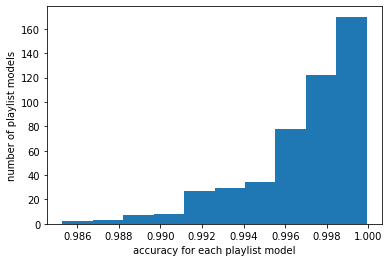

plot of mean cv scores for k=5 for multiple play lists


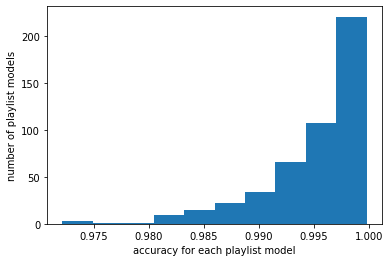

plot of mean cv scores for k=7 for multiple play lists


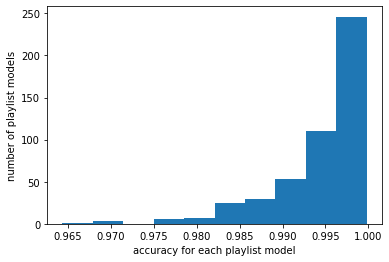

plot of mean cv scores for k=10 for multiple play lists


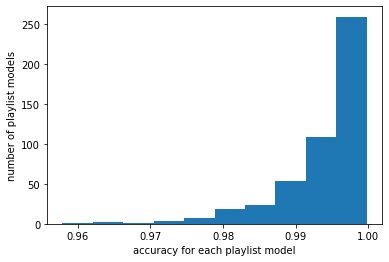

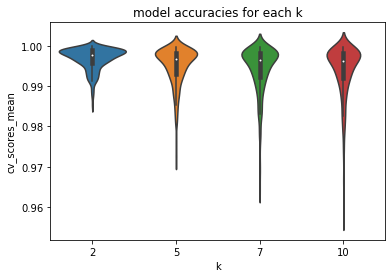

In [270]:
output = pd.DataFrame(output)

sns.violinplot(x=output.k,y=output.accuracy_mean)
plt.title("model accuracies for each k")
plt.show()

for k in ks:
    print(f"plot of mean cv scores for k={k} for multiple play lists")
    subset = output.loc[output.k==k,:]
    plt.hist(subset["accuracy_mean"])
    plt.xlabel("accuracy for each playlist model")
    plt.ylabel("number of playlist models")
    plt.show()
    



In [ ]:
ks = [2, 5, 7, 10]
output = []
playlists = range(0, len(playlist_numbers))

total_loops = len(playlists) * len(ks)
with tqdm_notebook(total=total_loops) as pbar:
    for playlist in playlists:
        for k in ks:
            # https://towardsdatascience.com/building-a-k-nearest-neighbors-k-nn-model-with-scikit-learn-51209555453a
#             print(f'''**************************************'''
#                   f'''\nRunning kNN classification for k={k}''')
            knn_cv = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
            cv_scores = cross_val_score(knn_cv, X_train, y_train[:, playlist], cv=5, scoring='F1')
            output.append({"k": k, "cv_scores_mean": np.mean(cv_scores), "playlist": playlist})
#             print(f'''cv_scores: {cv_scores}''')
#             print(f'''cv_scores mean: {np.mean(cv_scores)}''')
            pbar.update(1)
